AI-ассистент для подбора недвижимости

Создание файла со списком зависимостей для проекта

In [ ]:
%%writefile requirements.txt
llama-index
llama-index-core
llama-index-llms-huggingface
llama-index-embeddings-huggingface
llama-index-packs-tables
transformers
torch
accelerate
safetensors
sentence-transformers
pandas
numpy
requests
selectolax
sympy
nest-asyncio
arize-phoenix
arize-phoenix-otel
openinference-instrumentation-llama_index
opentelemetry-api
opentelemetry-sdk
chromadb
nemoguardrails
tensorflow
peft
bitsandbytes
tf-keras

Overwriting requirements.txt


Установка всех необходимых зависимостей из ранее созданного requirements.txt и импорт всех необходимых библиотек

In [ ]:
!pip install -r requirements.txt

In [ ]:
from llama_index.core import Settings, VectorStoreIndex, Document
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.core import StorageContext
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.indices.vector_store import VectorIndexRetriever

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from transformers import BitsAndBytesConfig

import torch
import pandas as pd

import os
import json
import csv
import requests

from selectolax.parser import HTMLParser

import nest_asyncio

import phoenix as px
from phoenix.otel import register
from phoenix.trace.schemas import SpanAttributes

from openinference.semconv.trace import SpanAttributes
from chromadb.telemetry.opentelemetry import tracer

In [ ]:
Установка токена доступа для Hugging Face через переменные окружения

In [ ]:
HF_TOKEN = ""
os.environ["HUGGINGFACE_ACCESS_TOKEN"] = HF_TOKEN

В качестве базы данных объявлений о продаже недвижимости был выбран сайт Яндекс Недвижимость. Небольшим парсером получаем список объявлений в Иркутске и сохраняем его в csv.


In [ ]:
def write_csv(filename, data):
    with open(filename, 'a', encoding = 'utf-8', newline= '') as file:
          writer = csv.DictWriter(file, fieldnames=data[0].keys())
          if os.path.getsize(filename) < 100:
            writer.writeheader()
          writer.writerows(data)

def get_offers(response, filename):
    response.encoding = 'utf-8'
    html = response.text
    tree = HTMLParser(html)
    script = tree.css_first('script[id="initial_state_script"]').text()
    script = script[23:-1]

    data = json.loads(script)
    try:
        page_number = int(data['routing']['locationBeforeTransitions']['query']['page'])
    except Exception as e:
        page_number = 0

    offers = data['map']['offers']['points']

    for offer in offers:
        url_offer = offer['url']
        creation_date = offer['creationDate']
        price = offer['price']['value']
        area = offer['area']['value']
        location = offer['location']['geocoderAddress']
        rooms = offer['roomsTotal']

        data_offer = {
            'url': url_offer,
            'creation_date': creation_date,
            'price': price,
            'area': area,
            'location': location,
            'rooms': rooms
        }
        write_csv(filename, [data_offer])

    return page_number

def parse_offers(filename):
    page = 1
    page_number =0
    url = "https://realty.yandex.ru/irkutsk/kupit/kvartira/"
    while True:
        params = (('page', page),)
        response = requests.get(url, params = params)
        try:
          page_number = get_offers(response, filename)
        except Exception as e:
            print('')
        if page_number != page:
            break

        page += 1

In [ ]:
filename = 'yandex-realty.csv'
parse_offers(filename)
df = pd.read_csv(filename,  header=0, usecols=None)
print(df.head())


                                            url         creation_date  \
0  //realty.yandex.ru/offer/7729688670808619777  2025-03-19T09:17:45Z   
1  //realty.yandex.ru/offer/8446242752011937281  2024-11-27T08:09:35Z   
2  //realty.yandex.ru/offer/5025176553918360321  2025-03-21T05:59:28Z   
3            https://macroserver.ru/id/4769366/  2025-01-06T12:09:46Z   
4  //realty.yandex.ru/offer/8596155632484604522  2025-03-22T02:48:21Z   

      price   area                                           location  rooms  
0   6507121  44.00            Россия, Иркутск, Байкальская улица, 266      2  
1  10226800  69.10  Россия, Иркутский муниципальный округ, рабочий...      3  
2   6900000  51.80                 Россия, Иркутск, улица Лызина, 20А      2  
3  14797664  87.25  Россия, Иркутск, Октябрьский округ, микрорайон...      2  
4   4500000  41.30                    Россия, Иркутск, улица Мира, 62      2  


Как мера борьбы с галлюцинациями приводим данные в порядок: убираем дубликаты, чиним ссылки, приводим колонку с датой к типу даты и преобразуем цену и площадь в числовые значения.

In [ ]:
df['url'] = df['url'].apply(lambda x: 'https:' + x if x.startswith('//') else x)
df['creation_date'] = pd.to_datetime(df['creation_date'])

# Убираем дубликаты
df = df.drop_duplicates()

# Преобразуем цену и площадь в числовые значения
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['area'] = pd.to_numeric(df['area'], errors='coerce')

# Итог
df.head()

,url,creation_date,price,area,location,rooms
0,https://realty.yandex.ru/offer/772968867080861...,2025-03-19 09:17:45+00:00,6507121,44.00,"Россия, Иркутск, Байкальская улица, 266",2
1,https://realty.yandex.ru/offer/844624275201193...,2024-11-27 08:09:35+00:00,10226800,69.10,"Россия, Иркутский муниципальный округ, рабочий...",3
2,https://realty.yandex.ru/offer/502517655391836...,2025-03-21 05:59:28+00:00,6900000,51.80,"Россия, Иркутск, улица Лызина, 20А",2
3,https://macroserver.ru/id/4769366/,2025-01-06 12:09:46+00:00,14797664,87.25,"Россия, Иркутск, Октябрьский округ, микрорайон...",2
4,https://realty.yandex.ru/offer/859615563248460...,2025-03-22 02:48:21+00:00,4500000,41.30,"Россия, Иркутск, улица Мира, 62",2


Проверяем, что код выполняется на машине с GPU и скачиваем модель эмбеддинга.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2", device=device)

Скачиваем LLM модель. Выбор пал на русскоязычную модель saiga_yandexgpt_8b, основанную на модели Яндекса (https://huggingface.co/IlyaGusev/saiga_yandexgpt_8b)

In [ ]:
MODEL_NAME = "IlyaGusev/saiga_yandexgpt_8b"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_8bit=True,
    torch_dtype=torch.bfloat16,
    device_map=device
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/190k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

NameError: name 'GenerationConfig' is not defined

Определяем параметры квантования и рекомендуемые автором модели параметры.

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
print(generation_config)

GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 128009,
  "max_length": 1024000,
  "max_new_tokens": 2048,
  "pad_token_id": 0,
  "repetition_penalty": 1.1,
  "temperature": 0.6,
  "top_p": 0.95
}



Собираеми LLM модель

In [ ]:
llm = HuggingFaceLLM(
    model=model,             # модель
    model_name=MODEL_NAME,   # идентификатор модели
    tokenizer=tokenizer,     # токенизатор
    max_new_tokens=generation_config.max_new_tokens, # параметр необходимо использовать здесь, и не использовать в generate_kwargs, иначе ошибка двойного использования
    model_kwargs={"quantization_config": quantization_config}, # параметры квантования
    generate_kwargs = {   # параметры для инференса
      "bos_token_id": generation_config.bos_token_id, # токен начала последовательности
      "eos_token_id": generation_config.eos_token_id, # токен окончания последовательности
      "pad_token_id": generation_config.pad_token_id, # токен пакетной обработки (указывает, что последовательность ещё не завершена)
      "no_repeat_ngram_size": generation_config.no_repeat_ngram_size,
      "repetition_penalty": generation_config.repetition_penalty,
      "temperature": generation_config.temperature,
      "do_sample": True,
      "top_k": 50,
      "top_p": 0.95
    },
    device_map="auto",                         # автоматически определять устройство
)

Настраиваем глобальные параметры LLM

In [ ]:
Settings.llm = llm
Settings.embed_model = embedding_model
Settings.chunk_size = 512

Запускаем phoenix для трассировки модели

In [ ]:
nest_asyncio.apply()  # необходим для параллельных вычислений в среде ноутбуков
session = px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [ ]:
# configure the Phoenix tracer
tracer_provider = register(
  project_name="my-llm-app", # Default is 'default'
  auto_instrument=True # See 'Trace all calls made to a library' below
)
tracer = tracer_provider.get_tracer(__name__)

OpenTelemetry Tracing Details
|  Phoenix Project: my-llm-app
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



Определяем функцию построения индексов на основе наших данных

In [ ]:
def build_index(df):
    documents = [
        Document(
            text=(
                f"Цена: {row['price']} руб.\n"
                f"Площадь: {row['area']} м²\n"
                f"Комнат: {row['rooms']}\n"
                f"Адрес: {row['location']}\n"
                f"Ссылка: {row['url']}"
            )
        )
        for _, row in df.iterrows()
    ]
    return VectorStoreIndex.from_documents(documents, embed_model=embedding_model)

Задаем функцию генерации ответа моделью

In [ ]:
def process_user_query(user_query, system_prompt, query_engine):
    with tracer.start_as_current_span("query") as span:
        prompt = tokenizer.apply_chat_template([
            {"role": "system","content": system_prompt},
            {"role": "user","content": user_query}], tokenize=False, add_generation_prompt=True)
        response = query_engine.query(prompt)

        span.set_attribute(SpanAttributes.INPUT_VALUE, prompt)
        span.set_attribute(SpanAttributes.OUTPUT_VALUE, response.response )

    return response.response

Создаем индекс ,движок запросов и промпт нейро-сотрудника.


Для лучшего ранжирования данных используем VectorIndexRetriever и RetrieverQueryEngine

In [ ]:
index = build_index(df)
retriever = VectorIndexRetriever(index=index, similarity_top_k=5)
query_engine = RetrieverQueryEngine(retriever=retriever)

In [ ]:
system_prompt = f"""
    Ты – AI-ассистент по недвижимости. Твоя задача – помогать пользователям находить подходящие объекты, анализировать цены и предлагать актуальную информацию.
    Твои функции:
    1.Принимать запросы, уточнять параметры поиска.
    2.Искать объекты по заданным критериям, предоставлять ключевые данные.
    3.Оповещать о новых объектах и изменении цен.
    4.Давать сравнительный анализ и персонализированные рекомендации.
    5.Вежливо и чётко отвечать, предлагать альтернативные решения.

    Важно:
    Используй только актуальные данные.
    Соблюдай конфиденциальность.
    Запрашивай уточнения, если информации недостаточно.
    """

Выполняем тестовый запрос

In [ ]:
query = "Найдите однокомнатную квартиру в Маркова."
response = process_user_query(query, system_prompt, query_engine)
print(response)

C:\Users\user\miniconda3\Lib\site-packages\bitsandbytes\autograd\_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



В рабочем посёлке Маркова есть две однокомнатные квартиры с ценами 5 760 000 рублей (площадью 44.23 м²) и 6 063 000 рублей (также площадью 44.23 м²). Обе расположены в Юго-Западном микрорайоне. Какой вариант вас больше интересует? Есть ли дополнительные требования к квартире или району?


Изучаем трассировку в phoenix. Судя по ней, галлюцинации на этом запросе отсутствуют

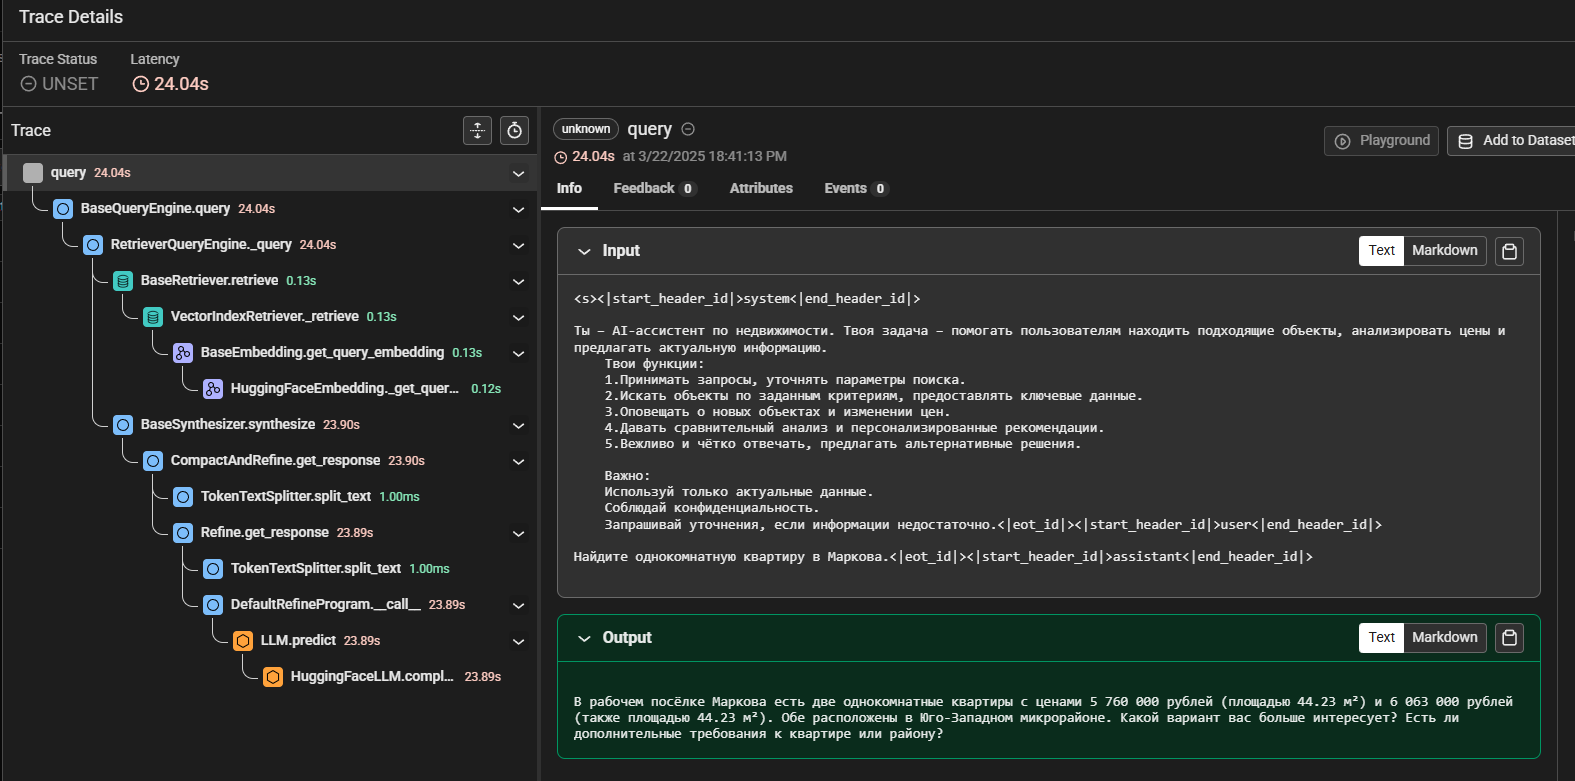